**MACHINE LEARNING**

**HRV for detecting arousal**

In [40]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut, KFold, GridSearchCV
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet

In [3]:
# Loading the dataset
#file = r"C:\Users\Salin\OneDrive\Documentos\ESSEX\DSPROJECT\PPG_HR_Analysis_Longer_Intervals_\PPG\merged_features_norm_grey_arousal.csv"
file = r"C:\Users\Salin\OneDrive\Documentos\ESSEX\DSPROJECT\PPG_HR_Analysis_Longer_Intervals_\PPG\merged_features_norm_grey_new_arousal.csv"
df = pd.read_csv(file)

# Displaying info
df.head()
len(df)

2052

In [4]:
X = df.drop(columns=['Participant', 'Stimulus', 'Arousal'])
y = df['Arousal']
groups = df['Participant']

In [5]:
def evaluate_regression(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)

    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R² Score: {r2:.3f}")
    return

**XGBOOST REGRESSOR**

In [6]:
logo = LeaveOneGroupOut()

In [7]:
true_values = []
predicted_values = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

print("LOPO without hyperparameter tuning:")
evaluate_regression(true_values, predicted_values)


LOPO without hyperparameter tuning:
RMSE: 0.168
MAE: 0.132
R² Score: 0.227


In [8]:
global_corr = X.corrwith(y)
global_corr = global_corr.sort_values(key=abs, ascending=False)
global_corr.head(10)

F1_CrossingPoints   -0.351969
pVLF                -0.151748
aVLF                -0.109718
pLF                  0.100511
F3_MaxArea          -0.086162
nLF                  0.071986
F9_KurtX            -0.060054
aTotal              -0.053120
nHF                 -0.046888
NN50                -0.045010
dtype: float64

In [9]:
# Checking number of missing values per column
missing_counts = X.isna().sum()

# Displaying only columns that have missing values
missing_counts[missing_counts > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [10]:
X_mi = X.copy()

# Filling NaNs with column means 
X_mi = X_mi.fillna(X_mi.mean())

<Axes: title={'center': 'Mutual Information Scores'}>

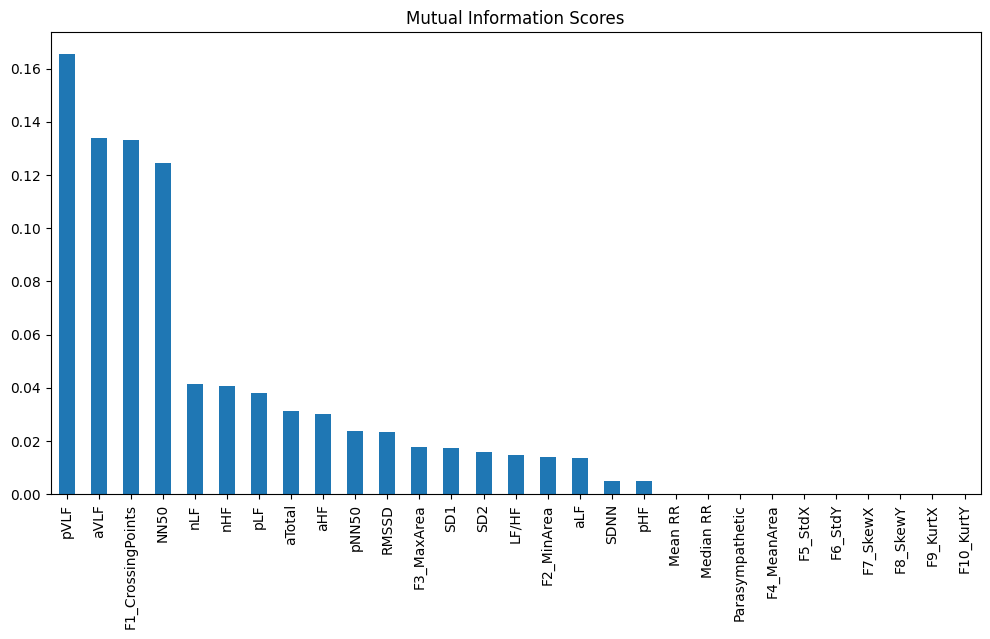

In [11]:
# MI between each feature and arousal
mi_scores = mutual_info_regression(X_mi, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns)
mi_series.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6), title='Mutual Information Scores')

In [12]:
mi_series.sort_values(ascending=False).head(20)

pVLF                 0.165426
aVLF                 0.133885
F1_CrossingPoints    0.133037
NN50                 0.124604
nLF                  0.041493
nHF                  0.040712
pLF                  0.037955
aTotal               0.031338
aHF                  0.030152
pNN50                0.023663
RMSSD                0.023284
F3_MaxArea           0.017775
SD1                  0.017523
SD2                  0.015862
LF/HF                0.014821
F2_MinArea           0.014177
aLF                  0.013822
SDNN                 0.004924
pHF                  0.004887
Mean RR              0.000000
dtype: float64

In [33]:
selected_features = selected_features = mi_series[mi_series > 0.02].index.tolist()
X = df[selected_features]
X.head()

RMSSD      NN50     pNN50      aVLF       aHF    aTotal       pVLF  \
0  0.352012 -0.471698  0.199388 -1.000000  1.194322  0.949087  -1.000000   
1  0.700875 -0.528302  0.278150 -1.000000  0.537748  0.463529  -1.000000   
2  0.587072 -0.811321  0.219158 -1.000000  2.454736  1.874433  -1.000000   
3  0.246371 -0.169811  0.162264  8.750069 -0.468002 -0.413262  15.617413   
4  0.242915 -0.547170 -0.024673 -1.000000  0.637673  0.515692  -1.000000   

        pLF       nLF       nHF  F1_CrossingPoints  
0 -0.616404 -0.617551  0.122455          -0.538462  
1 -0.237624 -0.239903  0.047571          -0.532967  
2 -1.000000 -1.000000  0.198291          -0.802198  
3  0.187468  0.245816 -0.048743          -0.049451  
4 -0.387740 -0.389570  0.077248          -0.560440

In [34]:
filtered_df = df.dropna(subset=selected_features + ['Arousal'])  # Keeping only valid raws
print(f"Total raws after deleting the Nans:", len(filtered_df))

Total raws after deleting the Nans: 2052


In [35]:
X = filtered_df[selected_features]
y = filtered_df['Arousal']
groups = filtered_df['Participant']

In [36]:
true_values = []
predicted_values = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

print("LOPO without hyperparameter tuning with most significant features:")
evaluate_regression(true_values, predicted_values)

LOPO without hyperparameter tuning with most significant features:
RMSE: 0.169
MAE: 0.132
R² Score: 0.218


In [31]:
true_values = []
predicted_values = []
results = [] 
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    test_participant = groups.iloc[test_idx].unique()[0]

    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(XGBRegressor(random_state=42), param_grid,
                        cv=inner_cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

    rmse = root_mean_squared_error(y_test, y_pred)

    # Saving Parameters 
    results.append({
        'Participant': test_participant,
        'RMSE': rmse,
        **grid.best_params_
    })

print("Nested LOPO with hyperparameter tuning:")
evaluate_regression(true_values, predicted_values)

# For further use if necessary to check the best parameters
results_df = pd.DataFrame(results)
params_df = results_df.drop(columns=['Participant', 'RMSE'])

Nested LOPO with hyperparameter tuning:
RMSE: 0.154
MAE: 0.128
R² Score: 0.350


Best Parameters per Participant

To understand whether certain model configurations generalize better, the best hyperparameters selected during each LOPO iteration were tracked.

Below:
- The most commonly selected configuration.
- The configuration that resulted in the lowest average RMSE across participants.


In [18]:
# The most used configuration
most_common_configs = (
    params_df.value_counts()
    .reset_index(name='Count')
    .sort_values(by='Count', ascending=False)
    .head(3)
)
print("Most Common Configurations:")
display(most_common_configs)

# The best config for better results
best_avg_configs = (
    results_df
    .groupby(['n_estimators', 'max_depth', 'learning_rate', 'subsample'])['RMSE']
    .mean()
    .reset_index()
    .sort_values(by='RMSE')
    .head(3)
)
print("Best Performing Configurations (Lowest Avg. RMSE):")
display(best_avg_configs)


Most Common Configurations:


learning_rate  max_depth  n_estimators  subsample  Count
0           0.01          3           200        1.0     23
1           0.01          3           200        0.8     22
2           0.01          5           200        0.8      6

Best Performing Configurations (Lowest Avg. RMSE):


n_estimators  max_depth  learning_rate  subsample      RMSE
1           200          3           0.01        1.0  0.149731
0           200          3           0.01        0.8  0.150436
2           200          5           0.01        0.8  0.153039

**Random Forest Regressor**

In [19]:
true_values = []
predicted_values = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

evaluate_regression(true_values, predicted_values)
    

RMSE: 0.156
MAE: 0.125
R² Score: 0.340


In [20]:
true_values = []
predicted_values = []
best_params_list = []

# Hyperparameters tunning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    grid = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid,
        cv=inner_cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)
    best_params_list.append(grid.best_params_)

evaluate_regression(true_values, predicted_values)

RMSE: 0.154
MAE: 0.122
R² Score: 0.357


In [21]:
best_params_df = pd.DataFrame(best_params_list)
print("\nBest hyperparameters per participant:")
display(best_params_df.value_counts().head())


Best hyperparameters per participant:


max_depth  min_samples_leaf  min_samples_split  n_estimators
10         2                 2                  200             22
                             5                  200             21
                             2                  100              7
           1                 2                  200              3
           2                 5                  100              1
Name: count, dtype: int64

Support Vector Regressor

In [38]:
true_values = []
predicted_values = []


for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = make_pipeline(
        StandardScaler(),
        SVR(kernel='rbf', C=1.0, gamma='scale')
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

# 
print("SVR (rbf) with LOPO Results:")
evaluate_regression(true_values, predicted_values)

SVR (rbf) with LOPO Results:
RMSE: 0.170
MAE: 0.139
R² Score: 0.207


In [39]:
true_values = []
predicted_values = []
results = []

param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__gamma': ['scale', 0.01, 0.001],
    'svr__kernel': ['rbf']
}

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    test_participant = groups.iloc[test_idx].unique()[0]

    pipeline = make_pipeline(StandardScaler(), SVR())

    
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # GridSearchCV 
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)

    true_values.extend(y_test)
    predicted_values.extend(y_pred)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append({
        'Participant': test_participant,
        'RMSE': rmse,
        **grid.best_params_
    })

print("SVR (rbf) + Hyperparameter Tuning (LOPO):")
evaluate_regression(true_values, predicted_values)

results_df = pd.DataFrame(results)
params_df = results_df.drop(columns=['Participant', 'RMSE'])

SVR (rbf) + Hyperparameter Tuning (LOPO):
RMSE: 0.170
MAE: 0.139
R² Score: 0.209
